In [34]:
import numpy as np
import pandas as pd
from empyrical import cum_returns, annual_return, annual_volatility, max_drawdown
from typing import NoReturn, List, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
def win_rate(returns: pd.Series) -> float:
    """
    给定日度收益率，计算胜率.

    :param returns: pd.Series
        日度收益率.
    :return: float
        胜率.
    """

    return (returns > 0).sum() / len(returns)


class MAStrategy(object):
    """
    均线策略，交易方式为开盘交易.
    """
    def __init__(self,
                 n_short: int,
                 n_long: int,
                 close_price: pd.Series,
                 open_price: pd.Series,
                 start: str,
                 end: str):
        """

        :param n_short: int
            计算短均线的天数.
        :param n_long: int
            计算长均线的天数.
        :param close_price: pd.Series
            日度收盘价序列.
        :param open_price: pd.Series
            日度开盘价序列，是买入或卖出价格.
            开盘价序列和收盘价序列的index为字符串格式的日期且相同.
        :param start: str, YYYY-MM-DD
            策略开始日期，从这天收盘开始发出信号，因此要保证MA在这天开始有值.
            实际是下一天开始交易，下下天开始有收益，策略净值统计时间从下一天开始.
        :param end: str, YYYY-MM-DD
            策略结束日期，指的是发出信号的最后一天.
        """
        trade_days = list(close_price.index)  # 输入的所有交易日
        self.signal_days = trade_days[trade_days.index(start):(trade_days.index(end)+1)]  # 所有有信号的日期
        self.ret_days = trade_days[(trade_days.index(start)+2):(trade_days.index(end)+3)]  # 所有计算收益率的日期
        self.nav_days = trade_days[(trade_days.index(start)+1):(trade_days.index(end)+3)]  # 净值统计区间
        self.close = close_price
        self.open = open_price
        self.n_short = n_short
        self.n_long = n_long

    def back_test(self) -> NoReturn:
        """
        回测.

        :return: NoReturn
        """
        ooret = ((self.open - self.open.shift(1)) / self.open).loc[self.ret_days]  # 开开收益率
        ma_short = self.close.rolling(self.n_short).mean().loc[self.signal_days]  # MA
        ma_long = self.close.rolling(self.n_long).mean().loc[self.signal_days]
        buy_signals = np.where(
            ma_short > ma_long,
            1,
            0
        )  # 每日交易信号
        sell_signals = np.where(
            ma_short < ma_long,
            -1,
            0
        )
        hold_signals = np.where(
            ma_short == ma_long,
            np.nan,
            0
        )
        signals = pd.Series((buy_signals + sell_signals + hold_signals), index=ooret.index)
        signals.fillna(method='ffill')
        self.returns = ooret * signals  # 实际每日收益率
        self.nav = pd.Series([1] + cum_returns(self.returns, 1).tolist(), index=self.nav_days)  # 每日净值
        self.ma_long = ma_long
        self.ma_short = ma_short
        self.act_close = self.close.loc[self.signal_days]
        self.signals = signals
        self.ooret = ooret

    def performance(self) -> pd.Series:
        """
        评价回测绩效.

        :return: pd.Series
            每个绩效指标及对应的值.
        """
        temp = pd.Series(
            [
                annual_return(self.returns),
                annual_volatility(self.returns),
                max_drawdown(self.returns),
                (annual_return(self.returns) - 0.05) / annual_volatility(self.returns),
                win_rate(self.returns)
            ],
            index=[
                '年化收益率',
                '年化波动率',
                '最大回撤',
                '夏普比率',
                '胜率'
            ]
        )

        return temp

# 1 策略说明
----
采用均线策略对4个品种进行回测，回测时间是2016年1月4日至2021年3月24日，交易方式如下：  
- 每天收盘后计算过去20日收盘价的移动平均价MA(20)；
- 若当天的收盘价大于MA(20)，则以第二日开盘价开一单多仓（若当前有多单则继续持有，若当前有空单则先平掉空单）；
- 若当天的收盘价小于MA(20)，则以第二日开盘价开一单空仓（若当前有空单则继续持有，若当前有多单则先平掉多单）；
- 若当天的收盘价等于MA(20)，则维持仓位不变。

*对回测进行简化处理，不考虑各类交易成本，且无杠杆。*

## 1.1 沪铜

In [3]:
cate1 = pd.read_excel('沪铜.xlsx', index_col=2)
cate1.index = cate1.index.astype(str)

In [16]:
cate1

,代码,名称,开盘价(元),最高价(元),最低价(元),收盘价(元),结算价,成交额(百万),成交量,持仓量
日期,,,,,,,,,,
1995-04-17,CU.SHF,SHFE铜,29150,29180,29110,29130,29140,0.00,2600,22240
1995-04-18,CU.SHF,SHFE铜,29200,29320,29200,29250,29260,0.00,4250,21870
1995-04-19,CU.SHF,SHFE铜,29230,29230,29080,29100,29110,0.00,4340,23230
1995-04-20,CU.SHF,SHFE铜,28520,28700,28520,28520,28520,0.00,10250,24360
1995-04-21,CU.SHF,SHFE铜,28510,28550,28050,28200,28200,0.00,17700,22170
...,...,...,...,...,...,...,...,...,...,...
2021-03-18,CU.SHF,SHFE铜,66920,67700,66660,66920,67120,49300.12,146886,149439
2021-03-19,CU.SHF,SHFE铜,66980,67390,65510,66020,66650,72565.01,217722,148049
2021-03-22,CU.SHF,SHFE铜,66510,67440,66220,66800,66820,60607.35,181394,146542


In [38]:
strategy1 = MAStrategy(
    1,
    20,
    cate1['收盘价(元)'],
    cate1['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy1.back_test()

沪铜品种的净值走势

<AxesSubplot:>

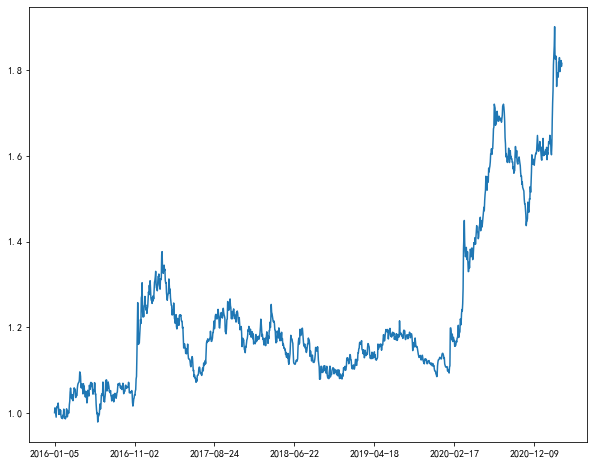

In [39]:
strategy1.nav.plot(figsize=(10, 8))

回测期内的绩效表现（计算夏普比率时取年化无风险利率为0.05）：

In [98]:
strategy1.performance()

年化收益率    0.125881
年化波动率    0.172143
最大回撤    -0.221946
夏普比率     0.440798
胜率       0.498818
dtype: float64

## 1.2 螺纹钢

In [4]:
cate2 = pd.read_excel('螺纹钢.xlsx', index_col=2)
cate2.index = cate2.index.astype(str)

In [13]:
strategy2 = MAStrategy(
    1,
    20,
    cate2['收盘价(元)'],
    cate2['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy2.back_test()

螺纹钢净值走势

<AxesSubplot:>

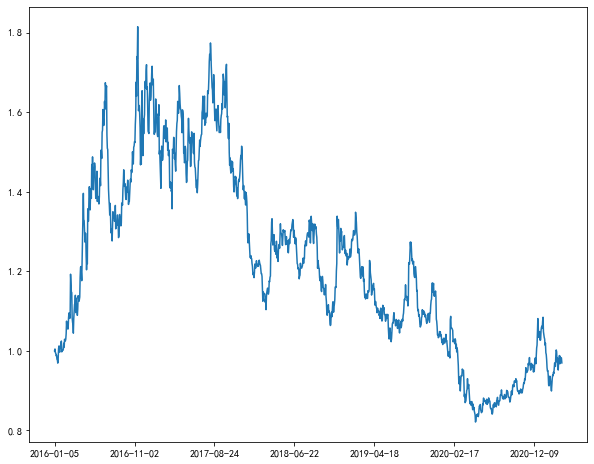

In [14]:
strategy2.nav.plot(figsize=(10, 8))

螺纹钢的回测表现

In [125]:
strategy2.performance()

年化收益率   -0.006147
年化波动率    0.299545
最大回撤    -0.547834
夏普比率    -0.187440
胜率       0.482270
dtype: float64

## 1.3 棉花

In [5]:
cate3 = pd.read_excel('棉花.xlsx', index_col=2)
cate3.index = cate3.index.astype(str)

In [18]:
strategy3 = MAStrategy(
    1,
    20,
    cate3['收盘价(元)'],
    cate3['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy3.back_test()

<AxesSubplot:>

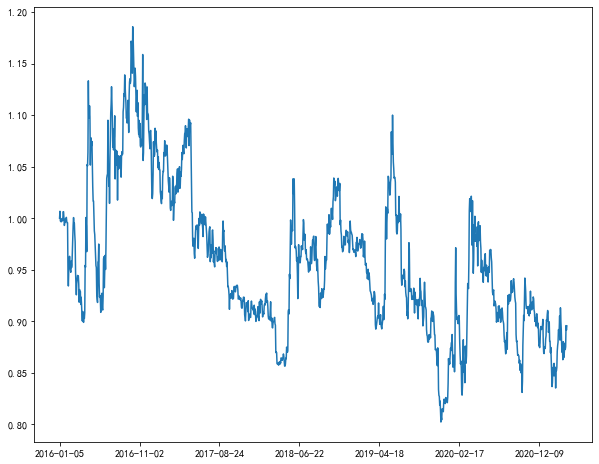

In [127]:
strategy3.nav.plot(figsize=(10, 8))

In [128]:
strategy3.performance()

年化收益率   -0.021677
年化波动率    0.223897
最大回撤    -0.323365
夏普比率    -0.320135
胜率       0.460993
dtype: float64

## 1.4 橡胶

In [6]:
cate4 = pd.read_excel('橡胶.xlsx', index_col=2)
cate4.index = cate4.index.astype(str)

In [28]:
strategy4 = MAStrategy(
    1,
    20,
    cate4['收盘价(元)'],
    cate4['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy4.back_test()

<AxesSubplot:>

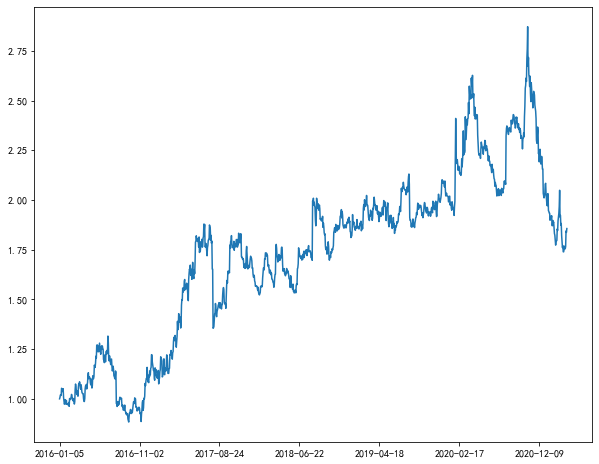

In [131]:
strategy4.nav.plot(figsize=(10, 8))

In [133]:
strategy4.performance()

年化收益率    0.130781
年化波动率    0.331520
最大回撤    -0.394508
夏普比率     0.243670
胜率       0.472813
dtype: float64

***在4个品种上测试策略的表现汇总如下：***

In [134]:
pd.concat(
    [
        strategy1.performance(),
        strategy2.performance(),
        strategy3.performance(),
        strategy4.performance()
    ],
    axis=1,
    keys=[
        '沪铜', '螺纹钢', '棉花', '橡胶'
    ]
)

,沪铜,螺纹钢,棉花,橡胶
年化收益率,0.125881,-0.006147,-0.021677,0.130781
年化波动率,0.172143,0.299545,0.223897,0.331520
最大回撤,-0.221946,-0.547834,-0.323365,-0.394508
夏普比率,0.440798,-0.187440,-0.320135,0.243670
胜率,0.498818,0.482270,0.460993,0.472813


各策略表现不算太好，由于均线策略受长短均线计算周期的影响，*考虑选定一段样本内时期，并在这段时期中根据年化收益选择最优的均线周期组合*

# 2 参数寻优
----
选定**2010年1月4日**至**2015年12月31日**为样本内用来寻找最优长短期参数组合的时期，短周期参数从1-20，长周期参数从5-120，但保证短周期参数<长周期参数，选择**年化收益**最大的一组参数。

In [7]:
period_comb = []
for m in range(1, 21):
    for n in range(5, 121):
        if m < n:
            period_comb.append((m, n))

In [35]:
def batch_test(df: pd.DataFrame,
               start: Optional[str] = '2010-01-04',
               end: Optional[str] = '2015-12-31') -> List:
    """
    批量回测，返回年化收益

    :param df: pd.DataFrame
        行情数据.
    :param start: str
    :param end: str
    :return: List
        每组参数对应的年化收益。
    """
    returns = []
    for i, j in period_comb:
        strategy = MAStrategy(
            n_short=i,
            n_long=j,
            close_price=df['收盘价(元)'],
            open_price=df['开盘价(元)'],
            start=start,
            end=end
        )
        strategy.back_test()
        returns.append(annual_return(strategy.returns))

    return returns

## 2.1 沪铜

In [152]:
returns1 = batch_test(cate1)

In [163]:
print(f'最优参数组合为：{period_comb[returns1.index(max(returns1))]}')

最优参数组合为：(10, 16)


**对于沪铜品种，当短周期均线天数为10，长周期均线天数为16时，样本内策略效果最好。** 

该组参数**样本内**策略表现如下：

<AxesSubplot:>

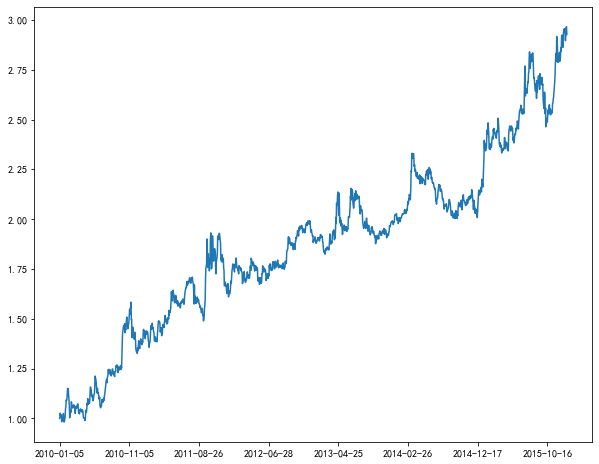

In [164]:
strategy1_in = MAStrategy(
    10,
    16,
    cate1['收盘价(元)'],
    cate1['开盘价(元)'],
    '2010-01-04',
    '2015-12-31'
)
strategy1_in.back_test()
strategy1_in.nav.plot(figsize=(10, 8))

比最开始在2016年至2021年的回测中使用（1,20）组合要好得多，我们再来看使用（10，16）这组参数在**样本外**的表现。

<AxesSubplot:>

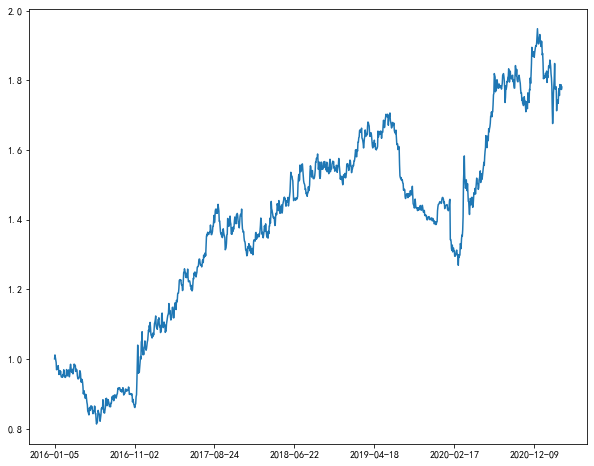

In [166]:
strategy1_out = MAStrategy(
    10,
    16,
    cate1['收盘价(元)'],
    cate1['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy1_out.back_test()
strategy1_out.nav.plot(figsize=(10, 8))

In [169]:
pd.concat(
[
    strategy1.performance(),
    strategy1_out.performance()
],
axis=1,
keys=['原始参数组合', '最优参数'])

,原始参数组合,最优参数
年化收益率,0.125881,0.121397
年化波动率,0.172143,0.172155
最大回撤,-0.221946,-0.256369
夏普比率,0.440798,0.414722
胜率,0.498818,0.516154


**并没有很明显的提升。**

## 2.2 螺纹钢

In [9]:
returns2 = batch_test(cate2)

In [11]:
print(f'最优参数组合为：{period_comb[returns2.index(max(returns2))]}')

最优参数组合为：(2, 24)


**对于螺纹钢品种，当短周期均线天数为2，长周期均线天数为24时，样本内策略效果最好。** 

该组参数**样本内**策略表现如下：

<AxesSubplot:>

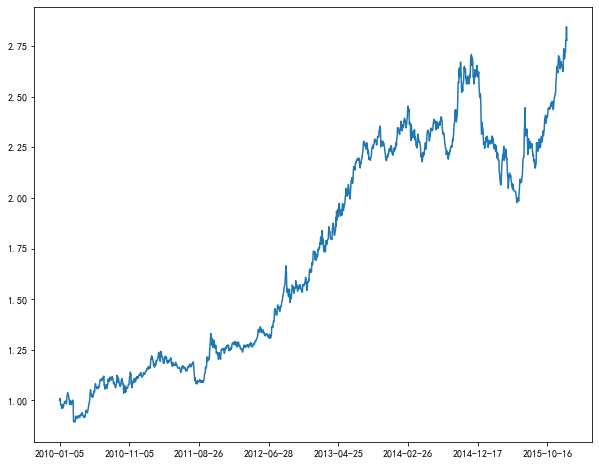

In [12]:
strategy2_in = MAStrategy(
    2,
    24,
    cate2['收盘价(元)'],
    cate2['开盘价(元)'],
    '2010-01-04',
    '2015-12-31'
)
strategy2_in.back_test()
strategy2_in.nav.plot(figsize=(10, 8))

比最开始在2016年至2021年的回测中使用（1,20）组合要好得多，我们再来看使用（2，24）这组参数在**样本外**的表现。

<AxesSubplot:>

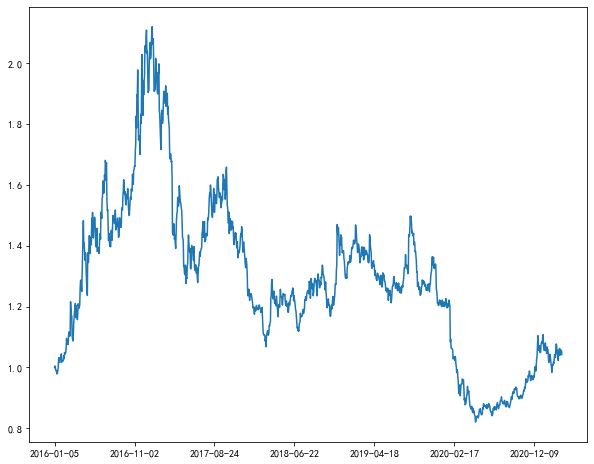

In [15]:
strategy2_out = MAStrategy(
    2,
    24,
    cate2['收盘价(元)'],
    cate2['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy2_out.back_test()
strategy2_out.nav.plot(figsize=(10, 8))

In [17]:
pd.concat(
[
    strategy2.performance(),
    strategy2_out.performance()
],
axis=1,
keys=['原始参数组合', '样本内最优参数'])

,原始参数组合,样本内最优参数
年化收益率,-0.006147,0.008193
年化波动率,0.299545,0.299536
最大回撤,-0.547834,-0.613120
夏普比率,-0.187440,-0.139573
胜率,0.482270,0.485422


略微有所提升，但提升依然不明显。

## 2.3 棉花

In [19]:
returns3 = batch_test(cate3)

In [20]:
print(f'最优参数组合为：{period_comb[returns3.index(max(returns3))]}')

最优参数组合为：(14, 66)


**对于棉花品种，当短周期均线天数为14，长周期均线天数为66时，样本内策略效果最好。** 

该组参数**样本内**策略表现如下：

<AxesSubplot:>

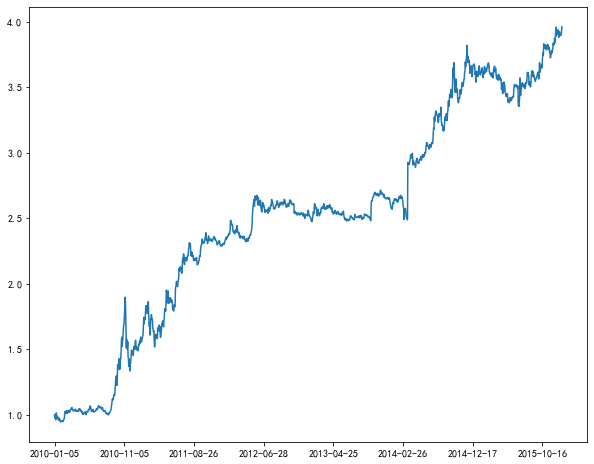

In [21]:
strategy3_in = MAStrategy(
    14,
    66,
    cate3['收盘价(元)'],
    cate3['开盘价(元)'],
    '2010-01-04',
    '2015-12-31'
)
strategy3_in.back_test()
strategy3_in.nav.plot(figsize=(10, 8))

比最开始在2016年至2021年的回测中使用（1,20）组合要好得多，我们再来看使用（14，66）这组参数在**样本外**的表现。

<AxesSubplot:>

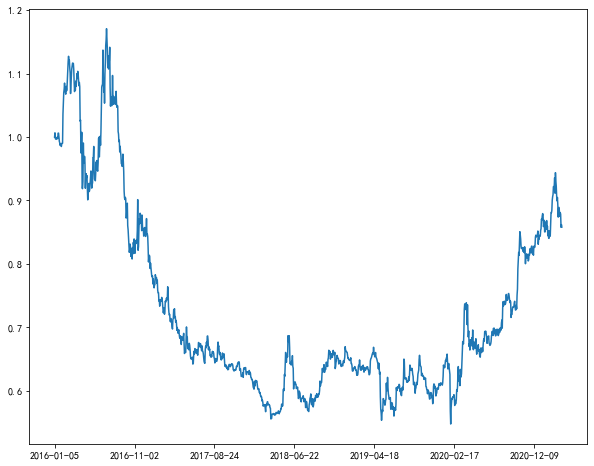

In [22]:
strategy3_out = MAStrategy(
    14,
    66,
    cate3['收盘价(元)'],
    cate3['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy3_out.back_test()
strategy3_out.nav.plot(figsize=(10, 8))

In [23]:
pd.concat(
[
    strategy3.performance(),
    strategy3_out.performance()
],
axis=1,
keys=['原始参数组合', '样本内最优参数'])

,原始参数组合,样本内最优参数
年化收益率,-0.021677,-0.029987
年化波动率,0.223897,0.223897
最大回撤,-0.323365,-0.532838
夏普比率,-0.320135,-0.357250
胜率,0.460993,0.481481


表现甚至变得更差。

## 2.4 橡胶

In [24]:
returns4 = batch_test(cate4)

In [25]:
print(f'最优参数组合为：{period_comb[returns4.index(max(returns4))]}')

最优参数组合为：(1, 63)


**对于橡胶品种，当短周期均线天数为1，长周期均线天数为63时，样本内策略效果最好。** 

该组参数**样本内**策略表现如下：

<AxesSubplot:>

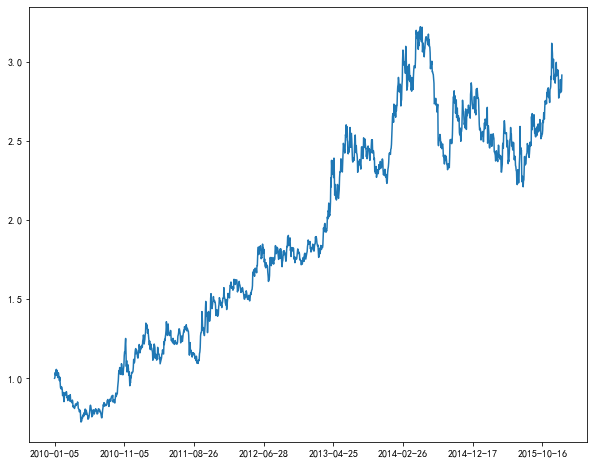

In [26]:
strategy4_in = MAStrategy(
    1,
    63,
    cate4['收盘价(元)'],
    cate4['开盘价(元)'],
    '2010-01-04',
    '2015-12-31'
)
strategy4_in.back_test()
strategy4_in.nav.plot(figsize=(10, 8))

比最开始在2016年至2021年的回测中使用（1,20）组合要好得多，我们再来看使用（1，63）这组参数在**样本外**的表现。

<AxesSubplot:>

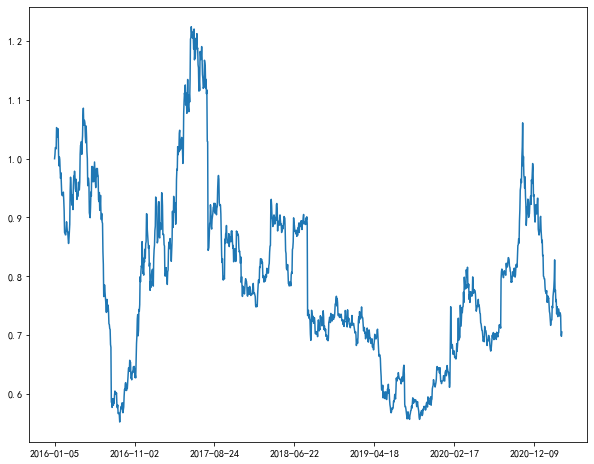

In [30]:
strategy4_out = MAStrategy(
    1,
    63,
    cate4['收盘价(元)'],
    cate4['开盘价(元)'],
    '2016-01-04',
    '2021-03-22'
)
strategy4_out.back_test()
strategy4_out.nav.plot(figsize=(10, 8))

In [31]:
pd.concat(
[
    strategy4.performance(),
    strategy4_out.performance()
],
axis=1,
keys=['原始参数组合', '样本内最优参数'])

,原始参数组合,样本内最优参数
年化收益率,0.130781,-0.067093
年化波动率,0.331520,0.332007
最大回撤,-0.394508,-0.545929
夏普比率,0.243670,-0.352683
胜率,0.472813,0.474389


对橡胶品种，样本内的最优参数在样本外测试的表现却比初始指定的（1，20）参数表现远差！

# 3 思考与后续
----
根据上述回测结果，我们有如下总结与思考：

**1 应用同一组长短周期参数，不同品种的均线策略结果差别很大。** 我们看到，在第一部分中，当我们在样本外时期用（1,20）这组参数时，沪铜和橡胶的年化收益能超过10%，但螺纹钢、棉花表现却不好。

**2 最优的均线策略要求我们能事先知道长短期均线的参数应该如何选择。** 此时均线策略很可能有很好的表现（参考第二部分样本内最优参数的表现），但遗憾的是，我们并不能事先知道应该选择哪一组参数，在第一部分的回测中能看到，众多散户（可能）用得较多的20天均线并不总是一个很好的选择，**甚至最优参数组合在不同时期是不同的**，为了说明这个问题，我们来按第二部分相同的方式在样本外期间寻找最优的参数并对比样本外的最优参数与原始参数表现。  

如下图，4个品种在样本外的最优参数下，表现都比原始参数好得多，但样本外的最优参数却不同于样本内的最优参数。

In [36]:
def find_best_out() -> NoReturn:
    """
    寻找样本外的最优参数并回测，画出净值的对比图.

    :return: NoReturn
    """
    temp1 = batch_test(cate1, '2016-01-04', '2021-03-22')
    temp2 = batch_test(cate2, '2016-01-04', '2021-03-22')
    temp3 = batch_test(cate3, '2016-01-04', '2021-03-22')
    temp4 = batch_test(cate4, '2016-01-04', '2021-03-22')

    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 2, 1)
    s1 = MAStrategy(
        period_comb[temp1.index(max(temp1))][0],
        period_comb[temp1.index(max(temp1))][1],
        cate1['收盘价(元)'],
        cate1['开盘价(元)'],
        '2016-01-04',
        '2021-03-22'
    )
    s1.back_test()
    s1.nav.plot(ax=ax1, label=f'最优参数组合{period_comb[temp1.index(max(temp1))]}')
    strategy1.nav.plot(ax=ax1, label='原始参数组合(1,20)')
    ax1.set_title('沪铜')
    ax1.legend()
    
    ax2 = fig.add_subplot(2, 2, 2)
    s2 = MAStrategy(
        period_comb[temp2.index(max(temp2))][0],
        period_comb[temp2.index(max(temp2))][1],
        cate2['收盘价(元)'],
        cate2['开盘价(元)'],
        '2016-01-04',
        '2021-03-22'
    )
    s2.back_test()
    s2.nav.plot(ax=ax2, label=f'最优参数组合{period_comb[temp2.index(max(temp2))]}')
    strategy2.nav.plot(ax=ax2, label='原始参数组合(1,20)')
    ax2.set_title('螺纹钢')
    ax2.legend()
    
    ax3 = fig.add_subplot(2, 2, 3)
    s3 = MAStrategy(
        period_comb[temp3.index(max(temp3))][0],
        period_comb[temp3.index(max(temp3))][1],
        cate3['收盘价(元)'],
        cate3['开盘价(元)'],
        '2016-01-04',
        '2021-03-22'
    )
    s3.back_test()
    s3.nav.plot(ax=ax3, label=f'最优参数组合{period_comb[temp3.index(max(temp3))]}')
    strategy3.nav.plot(ax=ax3, label='原始参数组合(1,20)')
    ax3.set_title('棉花')
    ax3.legend()
    
    ax4 = fig.add_subplot(2, 2, 4)
    s4 = MAStrategy(
        period_comb[temp4.index(max(temp4))][0],
        period_comb[temp4.index(max(temp4))][1],
        cate4['收盘价(元)'],
        cate4['开盘价(元)'],
        '2016-01-04',
        '2021-03-22'
    )
    s4.back_test()
    s4.nav.plot(ax=ax4, label=f'最优参数组合{period_comb[temp4.index(max(temp4))]}')
    strategy4.nav.plot(ax=ax4, label='原始参数组合(1,20)')
    ax4.set_title('棉花')
    ax4.legend()

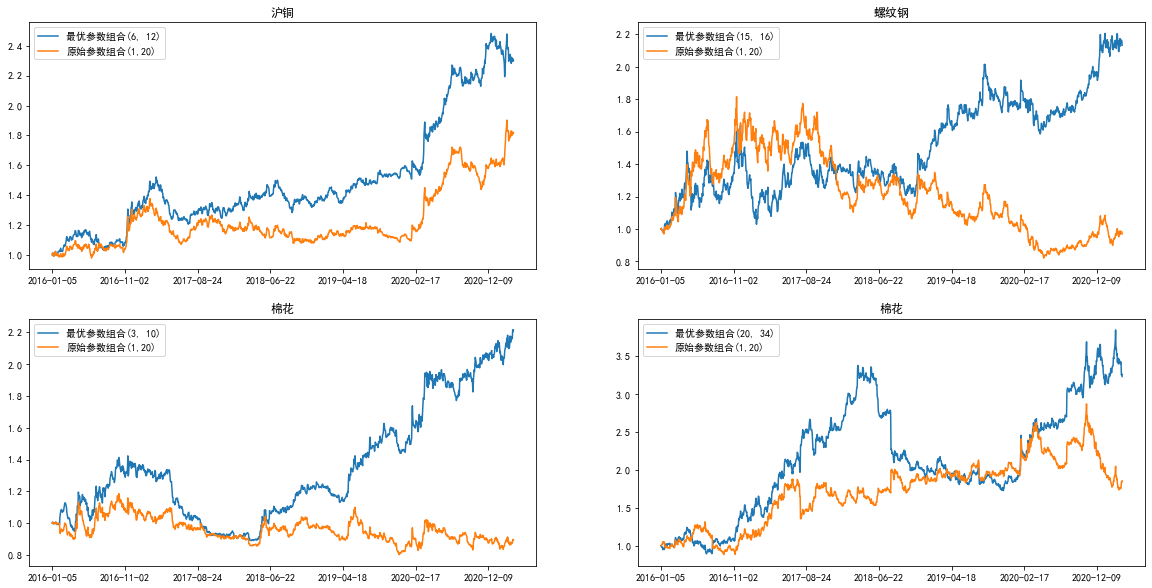

In [40]:
find_best_out()

**3 通过上述第2点的分析，可以得到另外一个很明显的结论：同一个品种在同一段时期，应用不同的参数，策略表现差异也很大。**



4 目前为止，无论是在样本内还是在样本外，我们找到的最优参数组中，长周期天数最长的也只是60天左右，应用均线进行判断的个人交易者***或许***能从中得到一个结论：选择均线的天数时，过长周期并不是一个好的选择。